# Astroball Astrocat Docking Control System

This cell imports all necessary modules required for the simulation, control design, and symbolic modeling of the spacecraft system.

In [1]:
# Import standard Python modules
import time                          # Used for tracking execution time
import matplotlib.pyplot as plt     # Used for plotting results
import sympy as sym                 # Used for symbolic computation
import numpy as np                  # Used for numerical operations and array handling
import control                      # Used for control system design and analysis
from IPython.display import display, Markdown  # Used for displaying formatted text output in the notebook

# Import spacecraft-specific modules
import ae353_spacecraft_design as design        # Design module provided for spacecraft model setup by Professor Tim Bretl
import ae353_spacecraft_simulate                # Interface to run the spacecraft simulator

# Configure NumPy to suppress scientific notation for small values
np.set_printoptions(suppress=True)


## Create spacecraft

This cell initializes and displays an interactive visualizer to assist with the placement of reaction wheels on the spacecraft. The visualizer helps in understanding how the wheel positions affect the dynamics of the system.


In [2]:
# Create a visualizer to assist with reaction wheel placement
vis = design.create_visualizer()

# Display the visualizer inside the notebook
vis.jupyter_cell()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


This cell specifies the positions of four reaction wheels using spherical coordinates: right ascension ($\alpha$) and declination ($\delta$). The locations are chosen to improve controllability of the spacecraft, and may differ from the initial template configuration.


In [3]:
# Specify the location of four reaction wheels using right ascension (alpha) and declination (delta)
wheels = [
    {"alpha": 0 * np.pi / 4 + np.pi / 3, "delta": np.arctan(0.6 / np.sqrt(3))},
    {"alpha": 2 * np.pi / 3 + np.pi / 3, "delta": np.arctan(0.6 / np.sqrt(3))},
    {"alpha": 4 * np.pi / 3 + np.pi / 3, "delta": np.arctan(0.6 / np.sqrt(3))},
    {"alpha": 0 * np.pi / 4, "delta": -np.pi / 2},  # This wheel points directly downward
]

This cell adds the specified reaction wheels to the visualizer and checks for potential issues. Warnings will appear if any wheel obstructs the star tracker or if any two wheels are positioned too closely together.


In [4]:
design.show_wheels(vis, wheels)

This cell generates a model of the spacecraft in URDF format, which will overwrite the existing `spacecraft.urdf` file. It also calculates the mass ($m$) and inertia matrix ($J$) of the spacecraft, including the reaction wheels.


In [5]:
# Create the spacecraft model in URDF format, including the specified reaction wheels
m, J = design.create_spacecraft(wheels)

# Display the computed mass and inertia matrix in LaTeX format for clarity
display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'  # Format and display the mass
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'  # Format and display the inertia matrix
    +  r'$$'
))


$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}22.04 & 0.0 & 0.0\\0.0 & 22.04 & 0.0\\0.0 & 0.0 & 22.13\end{matrix}\right]$$

## Create stars

This cell specifies the locations of up to ten stars in terms of their right ascension ($\alpha$) and declination ($\delta$). The positions are defined based on a circular arrangement with a set radius.

In [6]:
# The stars are placed in a circular arrangement with a specific radius (r)
r = 0.20

# Define the number of stars
num_stars = 8

# Generate star positions based on the circular arrangement
stars = []
for i in range(num_stars):
    theta = 2 * np.pi * i / num_stars  # Calculate the angle for each star
    alpha = r * np.cos(theta)          # Calculate the x-coordinate (alpha)
    delta = r * np.sin(theta)          # Calculate the y-coordinate (delta)
    stars.append({'alpha': alpha, 'delta': delta})  # Add the star's position to the list


This cell visualizes the locations of the stars in the star tracker’s field of view. The plot on the left shows the gridlines of right ascension ($\alpha$) and declination ($\delta$), while the plot on the right shows the corresponding gridlines for the $y_\text{star}$ and $z_\text{star}$ coordinates. This allows us to see where the stars are positioned relative to the star tracker’s orientation.


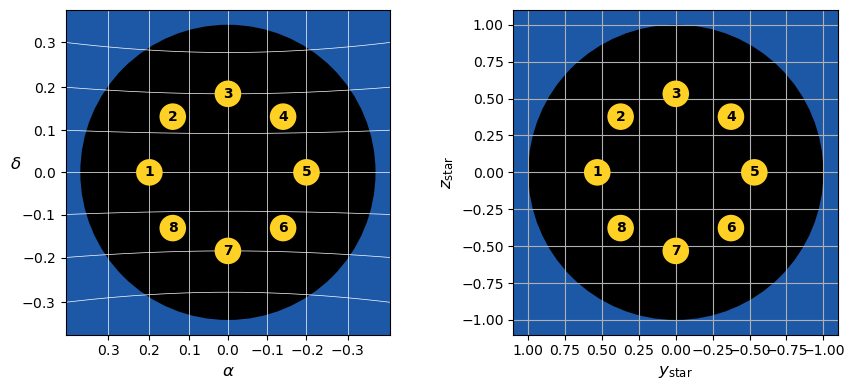

In [7]:
# Visualize the locations of the stars in the star tracker’s field of view
design.show_stars(stars)


This cell creates a file (`stars.json`) containing the locations of the stars defined earlier. The file will be stored in the `urdf` directory and will overwrite any existing `stars.json` file.


In [8]:
design.create_stars(stars)


## Create dynamic model

In this cell, we derive the equations of motion for the spacecraft's rotational dynamics. The yaw, pitch, and roll angles along with their angular velocities are defined symbolically. 

The torques exerted by the reaction wheels are calculated, and then the rotation matrices for the spacecraft's orientation are defined. The Euler's equations for rigid body rotation are formulated using the inertia matrix and the calculated torques. Finally, the full system of equations of motion is derived, including both the transformation from angular velocity to angular rates and the torque dynamics.


In [9]:
# Define yaw, pitch, roll angles as symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities in the x, y, and z directions
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques exerted by each reaction wheel
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute the resultant torques from each wheel
# Normalize the position vectors of each wheel and calculate the contribution of each torque
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])

# Total torque acting on the spacecraft
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices for yaw (psi), pitch (theta), and roll (phi)
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])  # Unit vector in the x direction
ey = sym.Matrix([[0], [1], [0]])  # Unit vector in the y direction
ez = sym.Matrix([[0], [0], [1]])  # Unit vector in the z direction

# Calculate the matrix that relates the angular velocity to the angular rates
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define the inertia matrix components (Jx, Jy, Jz) and apply them to Euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]

# Euler's equations of motion, incorporating torques and angular velocities
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Combine the transformation matrix and Euler's equations to get the full equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)


In this cell, we express the system of equations of motion for the spacecraft's rotational dynamics. The equations are written as a state-space form. This function is represented as:

$$
\begin{bmatrix} 
\dot{\psi} \\ 
\dot{\theta} \\ 
\dot{\phi} \\ 
\dot{w_x} \\ 
\dot{w_y} \\ 
\dot{w_z} 
\end{bmatrix} 
= f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).
$$

In [10]:
f

Matrix([
[                                                                                                                                                                       (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                    w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                        w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-78742598543589*tau_1/3673470740000000 + 78742598543589*tau_2/1836735370000000 - 472455591261533*tau_3/22040824440000000 - 612323399573677*tau_4/220408244400000000000000000000000 - 8497913*w_y*w_z/2204082444],
[                                         -818317088384971*tau_1/22040824440000000 - 57859122757771*tau_2/11020412220000000000000000000000 + 204579

In this step, we compute the matrices $A$ and $B$, which represent the linearized dynamics of the spacecraft. $A$ captures how the state evolves, and $B$ captures how the control inputs affect the state, both evaluated at the equilibrium point


In [11]:
# Use lambdify to convert the symbolic equations of motion 'f' into a numerical function 'f_num'
f_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f)

# Set equilibrium values where the system is at rest
psi_e = 0.  # Equilibrium yaw angle
theta_e = 0.  # Equilibrium pitch angle
phi_e = 0.  # Equilibrium roll angle
w_xe = 0.  # Equilibrium angular velocity in the x direction
w_ye = 0.  # Equilibrium angular velocity in the y direction
w_ze = 0.  # Equilibrium angular velocity in the z direction
tau_1e = 0.  # Equilibrium torque 1
tau_2e = 0.  # Equilibrium torque 2
tau_3e = 0.  # Equilibrium torque 3
tau_4e = 0.  # Equilibrium torque 4

# Define the state vector 'm' and the input torque vector 'n'
m = sym.Matrix([psi, theta, phi, w_x, w_y, w_z])  # State vector
n = sym.Matrix([tau_1, tau_2, tau_3, tau_4])  # Input torque vector
# Equilibrium state vector
m_e = sym.Matrix([psi_e,
                theta_e,
                phi_e,
                w_xe,
                w_ye,
                w_ze
])
# Equilibrium input vector
n_e = sym.Matrix([tau_1e,
                tau_2e,
                tau_3e,
                tau_4e
])
# Compute the Jacobian matrix with respect to the state vector 'm' at equilibrium values to get matrix A
A = f.jacobian(m).subs([(psi, psi_e), (theta, theta_e), (phi, phi_e), 
                        (w_x, w_xe), (w_y, w_ye), (w_z, w_ze),
                        (tau_1, tau_1e), (tau_2, tau_2e), (tau_3, tau_3e), (tau_4, tau_4e)])

# Convert the symbolic matrix A to a numerical matrix
A = np.array(A).astype(float)

# Compute the Jacobian matrix with respect to the input torque vector 'n' at equilibrium values to get matrix B
B = f.jacobian(n).subs([(psi, psi_e), (theta, theta_e), (phi, phi_e), 
                        (w_x, w_xe), (w_y, w_ye), (w_z, w_ze),
                        (tau_1, tau_1e), (tau_2, tau_2e), (tau_3, tau_3e), (tau_4, tau_4e)])

# Convert the symbolic matrix B to a numerical matrix
B = np.array(B).astype(float)


We check system controllability by computing the controllability matrix $W = [B\ AB\ A^2B\ \dots\ A^{n-1}B]$. If $W$ has full rank (equal to the number of states), the system is controllable. Otherwise, it is not.

In [12]:
# Initialize the controllability matrix W
W = B

# Get the number of states (the number of rows in matrix A)
shape = A.shape[0]

# Build the controllability matrix by concatenating powers of A multiplied by B
for i in range(1, shape):
    col = np.linalg.matrix_power(A, i) @ B  # Calculate A^i * B
    W = np.block([[W, col]])  # Add the column to the controllability matrix

# Convert the matrix to float64 type for numerical stability
W = W.astype(np.float64)

# Compute the rank of the controllability matrix
rank = np.linalg.matrix_rank(W)

# Print the size of the state vector and the rank of the controllability matrix
print("State vector size:", shape)
print("Controllability matrix rank:", rank)


State vector size: 6
Controllability matrix rank: 6


We use LQR to compute the gain matrix $K$, which minimizes a cost balancing state error and control effort. We then check that the closed-loop system is stable by verifying that its eigenvalues have negative real parts.


In [13]:
# Define equilibrium states and inputs (set to zero)
m_e = sym.Matrix([psi_e, theta_e, phi_e, w_xe, w_ye, w_ze])
n_e = sym.Matrix([tau_1e, tau_2e, tau_3e, tau_4e])

# Compute state and input deviations from equilibrium
x = m - m_e  # State error
u = n - n_e  # Control input deviation

# Define weighting matrices for LQR
Q = np.diag([500, 500, 500, 150, 150, 150])# State weighting matrix
R = np.diag([1,1,1,1]) * 1e-2 # Control input weighting matrix
# Compute the LQR gain matrix K using the LQR controller from the control library
K, _, _ = control.lqr(A, B, Q, R)

eigenvalues = np.linalg.eigvals(A - B @ K)  # Compute eigenvalues of the closed-loop system

#Check if all eigenvalues are real and have negative real parts for stability
if np.all(np.isclose(np.imag(eigenvalues), 0)) and np.all(np.real(eigenvalues) < 0):
    print("All eigenvalues are real with negative real parts.")
    print("LQR Gain Matrix K:")
    print(K)
    print("Closed-loop Eigenvalues:")
    print(eigenvalues)
else:
    print("Some eigenvalues have an imaginary part or positive real part.")

#Print the LQR gain matrix K
print(K)
#Print the weighting matrix R for reference
print(R)


All eigenvalues are real with negative real parts.
LQR Gain Matrix K:
[[ -63.671454   -158.11388301  -91.28709292  -62.60642107 -108.43750217
   -43.75095432]
 [ -63.671454      0.          182.57418584  125.21284214    0.
   -43.75095432]
 [ -63.671454    158.11388301  -91.28709292  -62.60642107  108.43750217
   -43.75095432]
 [ 194.51950503   -0.            0.            0.           -0.
   133.66137327]]
Closed-loop Eigenvalues:
[-6.06826821 -1.91444559 -1.91224397 -1.91224397 -6.13974712 -6.13974712]
[[ -63.671454   -158.11388301  -91.28709292  -62.60642107 -108.43750217
   -43.75095432]
 [ -63.671454      0.          182.57418584  125.21284214    0.
   -43.75095432]
 [ -63.671454    158.11388301  -91.28709292  -62.60642107  108.43750217
   -43.75095432]
 [ 194.51950503   -0.            0.            0.           -0.
   133.66137327]]
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]


## Create sensor model

In this step, we create a sensor model for the spacecraft. We define symbolic variables for the right ascension $\alpha$ and declination $\delta$ of each star to represent the positions of the stars in the sensor model.


In [14]:
# Create symbolic variables for the right ascension (alpha) and declination (delta) of each star
alpha, delta = sym.symbols('alpha, delta')

The sensor model for each star has the following form:

$$
\begin{bmatrix}
y_\text{star} \\
z_\text{star}
\end{bmatrix}
=
g(\psi, \theta, \phi, \alpha, \delta).
$$

In this model, the sensor readings (i.e., $y_\text{star}$ and $z_\text{star}$) depend on the spacecraft's orientation ($\psi$, $\theta$, $\phi$) and the star's location in the sky, defined by its right ascension ($\alpha$) and declination ($\delta$).


In this step, we create the sensor model for each star in the list and store them in a sequence. The final sensor model will be a vector where the measurements for each star (in terms of their $y$ and $z$ coordinates in the image frame) are stacked one after the other.

The final sensor model for all stars is:

$$
\begin{bmatrix}
y_{\text{star1}} \\
z_{\text{star1}} \\
y_{\text{star2}} \\
z_{\text{star2}} \\
\vdots \\
y_{\text{star n}} \\
z_{\text{star n}}
\end{bmatrix}
$$



In [15]:
# Create an empty list to store the sensor models for all stars
sensor_models = []

# Loop over each star in the stars list to generate a sensor model
for star in stars:
    alpha_val = star['alpha']  # Right ascension of the star
    delta_val = star['delta']  # Declination of the star
    
    # Position of star in the space frame (using spherical coordinates)
    p_star_in_space = sym.Matrix([
        [sym.cos(alpha) * sym.cos(delta)],
        [sym.sin(alpha) * sym.cos(delta)],
        [sym.sin(delta)]
    ])
    
    # Orientation of the body frame in space frame
    R_body_in_space = Rz * Ry * Rx
    
    # Position of star in the body frame (assuming the origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space
    
    # Position of star in the image frame
    r = sym.nsimplify(design.scope_radius)  # Assuming design.scope_radius is defined
    p_star_in_image = (1 / r) * sym.Matrix([
        [p_star_in_body[1] / p_star_in_body[0]],  # y-coordinate in the image frame
        [p_star_in_body[2] / p_star_in_body[0]]   # z-coordinate in the image frame
    ])
    
    # Simplify the sensor model for the current star
    g = sym.simplify(p_star_in_image, full=True)
    
    # Substitute the star's specific alpha and delta values
    g_substituted = g.subs({alpha: alpha_val, delta: delta_val})
    
    # Store the model for this star
    sensor_models.append(g_substituted[0])  # y-coordinate of the star
    sensor_models.append(g_substituted[1])  # z-coordinate of the star

# Stack all individual star sensor models into one vector
g_total = sym.Matrix(sensor_models)

# Optional: Substitute any specific values (if needed for evaluation)
g_total.subs([])  # sensor_models contains all individual g's

# Display the total sensor model
g_total


Matrix([
[                                                                                                                                                                                   21*(sin(phi)*sin(theta)*cos(psi - 0.2) - sin(psi - 0.2)*cos(phi))/(8*cos(theta)*cos(psi - 0.2))],
[                                                                                                                                                                                   21*(sin(phi)*sin(psi - 0.2) + sin(theta)*cos(phi)*cos(psi - 0.2))/(8*cos(theta)*cos(psi - 0.2))],
[            21*(0.990016655559523*sin(phi)*sin(theta)*cos(psi - 0.14142135623731) + 0.140950422896623*sin(phi)*cos(theta) - 0.990016655559523*sin(psi - 0.14142135623731)*cos(phi))/(8*(-0.140950422896623*sin(theta) + 0.990016655559523*cos(theta)*cos(psi - 0.14142135623731)))],
[            21*(0.990016655559523*sin(phi)*sin(psi - 0.14142135623731) + 0.990016655559523*sin(theta)*cos(phi)*cos(psi - 0.14142135623731) + 0.1409504228966

In this step, we evaluate the sensor model at the equilibrium point where the angles ($\phi$, $\theta$, and $\psi$) and angular velocities ($w_x$, $w_y$, $w_z$) are all set to their equilibrium values. This gives us the vector $g_e$, which represents the sensor readings for all stars in the equilibrium configuration.

In [16]:
# Evaluate the sensor model at the equilibrium point where the angles are set to their equilibrium values
g_e = g_total.subs([(phi, phi_e), (theta, theta_e), (psi, psi_e)])

# Convert the symbolic result to a numpy array and flatten it
g_e = np.array(g_e).flatten()

# Convert to float for numerical evaluation
g_e = g_e.astype(float)

# Display the shape and values of the equilibrium sensor model
g_e.shape, g_e


((16,),
 array([ 0.53211384,  0.        ,  0.37372589,  0.37749455,  0.        ,
         0.53211384, -0.37372589,  0.37749455, -0.53211384,  0.        ,
        -0.37372589, -0.37749455, -0.        , -0.53211384,  0.37372589,
        -0.37749455]))

In this step, we compute the Jacobian matrix $C$ of the sensor model with respect to the state vector. The Jacobian is calculated at the equilibrium point where the angles ($\phi$, $\theta$, and $\psi$) are all set to zero.


In [17]:
# Convert the symbolic sensor model to a numerical function
g_num = sym.lambdify([psi, theta, phi], g_total)

# Compute the Jacobian of the sensor model with respect to the state vector
C_num = sym.lambdify([psi, theta, phi], g_total.jacobian(x))

# Evaluate the Jacobian at the equilibrium point (0,0,0)
C = C_num(0, 0, 0)

# Convert the resulting matrix to float for numerical evaluation
C = C.astype(float)

# Display the shape of the Jacobian matrix
C.shape


(16, 6)

We check system observability by computing the observability matrix $W_c = \begin{bmatrix} C^\top & (CA)^\top & \dots & (CA^{n-1})^\top \end{bmatrix}^\top$. If its rank equals the number of states, the system is observable.

In [18]:
# Initialize observability matrix
W_c = C
shape = A.shape[0]  # Number of states

# Build the observability matrix iteratively
for i in range(1, shape):
    row = C @ np.linalg.matrix_power(A, i)
    W_c = np.block([[W_c], [row]])  # Stack new rows

# Convert to float
W_c = W_c.astype(np.float64)

# Compute rank of the observability matrix
rank_O = np.linalg.matrix_rank(W_c)

# Print results
print("Number of states (n):", shape)
print("Rank of Observability Matrix:", rank_O)

if rank_O == shape:
    print("The system is OBSERVABLE.")
else:
    print("The system is NOT OBSERVABLE.")



Number of states (n): 6
Rank of Observability Matrix: 6
The system is OBSERVABLE.


We compute the observer gain matrix $L$ using LQR, based on the system matrices $A$, $C$, and weights $Q_o$, $R_o$. The eigenvalues of $A - LC$ are checked to ensure observer stability.

In [19]:
from scipy import linalg

# Define the process and measurement noise covariance matrices
Q_o = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*1e-2
R_o = np.diag([1, 1, 1, 1, 1, 1])*1e-1

# Compute observer gain matrix L using LQR
Lt, _, _ = (control.lqr(A.T, C.T, np.linalg.inv(R_o), np.linalg.inv(Q_o)))
L = Lt.T

# Display results
print("Observer Gain Matrix L:")
print(L)

# Compute eigenvalues of the matrix (A - LC) to check stability
print(f'\np_o:\n{linalg.eigvals(A - L @ C)}')

# Print the observer gain matrix
print(L)


Observer Gain Matrix L:
[[-0.15447447  0.         -0.15138501 -0.0030379  -0.14837744  0.
  -0.15138501  0.0030379  -0.15447447  0.         -0.15138501 -0.0030379
  -0.14837744  0.         -0.15138501  0.0030379 ]
 [-0.          0.1483408   0.00303715  0.15140857 -0.          0.15443632
  -0.00303715  0.15140857 -0.          0.1483408   0.00303715  0.15140857
   0.          0.15443632 -0.00303715  0.15140857]
 [-0.         -0.25531347  0.18112561 -0.17931737  0.25531347 -0.
   0.18112561  0.17931737 -0.          0.25531347 -0.18112561  0.17931737
  -0.25531347 -0.         -0.18112561 -0.17931737]
 [-0.         -0.11189947  0.07938422 -0.0785917   0.11189947 -0.
   0.07938422  0.0785917  -0.          0.11189947 -0.07938422  0.0785917
  -0.11189947 -0.         -0.07938422 -0.0785917 ]
 [ 0.          0.10952321  0.00224239  0.11178822  0.          0.11402367
  -0.00224239  0.11178822  0.          0.10952321  0.00224239  0.11178822
  -0.          0.11402367 -0.00224239  0.11178822]
 [-0.11

This initializes the `Simulator` class from `ae353_spacecraft_simulate`, which interfaces with the PyBullet simulation engine for spacecraft simulation.


In [20]:
# Initialize the simulator
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,  # Display the simulation for development
    seed=None      # Random number generator seed
)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


This sets the camera view for the simulation run to the side view using the `camera_sideview` method from the `simulator` instance.


In [21]:
# Set the camera view to the side view for the simulation run
simulator.camera_sideview()


Define a controller that maps sensor measurements to actuator commands, using state feedback and an observer to estimate the spacecraft's state. The run function is called 25 times per second by the simulator.

In [36]:
class Controller:
    def __init__(self):
        # List of variables to log for the simulator
        self.variables_to_log = ['xhat']
        # Controller gains and system parameters
        self.K = K  # State feedback gain matrix
        self.L = L  # Observer gain matrix
        self.A = A  # State transition matrix
        self.B = B  # Input matrix
        self.C = C  # Output matrix
        # Equilibrium points
        self.psi_e = psi_e  # Equilibrium yaw angle
        self.theta_e = theta_e  # Equilibrium pitch angle
        self.phi_e = phi_e  # Equilibrium roll angle
        self.w_xe = w_xe  # Equilibrium angular velocity around x-axis
        self.w_ye = w_ye  # Equilibrium angular velocity around y-axis
        self.w_ze = w_ze  # Equilibrium angular velocity around z-axis
        # Equilibrium torque values
        self.tau_1e = tau_1e
        self.tau_2e = tau_2e
        self.tau_3e = tau_3e
        self.tau_4e = tau_4e
         # Equilibrium input vector
        self.n_e = n_e
        # Time step
        self.dt = 0.04
        #Equilibrium sensor model
        self.g_e =  g_e
    
    
    def reset(self):
        # Reset the state estimate
        self.xhat = np.array([0.,
                              0.,
                              0.,
                              0.,
                              0.,
                              0.])
    
    def run(self, t, star_measurements):

        # Compute control input (u) using state feedback
        u = -self.K @ self.xhat
        y = star_measurements - self.g_e
        # Update the state estimate (xhat) using observer dynamics
        self.xhat += self.dt * (self.A@self.xhat + self.B @ u - self.L@(self.C@self.xhat-y))
        # Set torque commands based on control input
        tau = u

        torque_1 = tau[0]
        torque_2 = tau[1]
        torque_3 = tau[2]
        torque_4 = tau[3]
        return torque_1, torque_2, torque_3, torque_4

This creates an instance of the `Controller` class using the previously defined system parameters and gain matrices.


In [37]:
controller = Controller()

This resets the simulator with random initial conditions, adds sensor noise, enables space debris, and sets the docking time to 60 seconds.

In [38]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [39]:
controller.reset()

This runs the simulator using the defined controller for a maximum duration of 65 seconds.

In [40]:
data = simulator.run(
    controller,            # Controller used to compute control inputs
    max_time=65.0,         # Maximum simulation time in seconds
    data_filename=None,    # File to save simulation data (set to None to disable)
    video_filename=None,   # File to save simulation video (set to None to disable)
    print_debug=False      # Whether to print debug information during simulation
)

Check if the space-cat has docked.

In [41]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


This plots the true and estimated values of the spacecraft's orientation and angular velocity states over time for visualizing controller and observer performance.

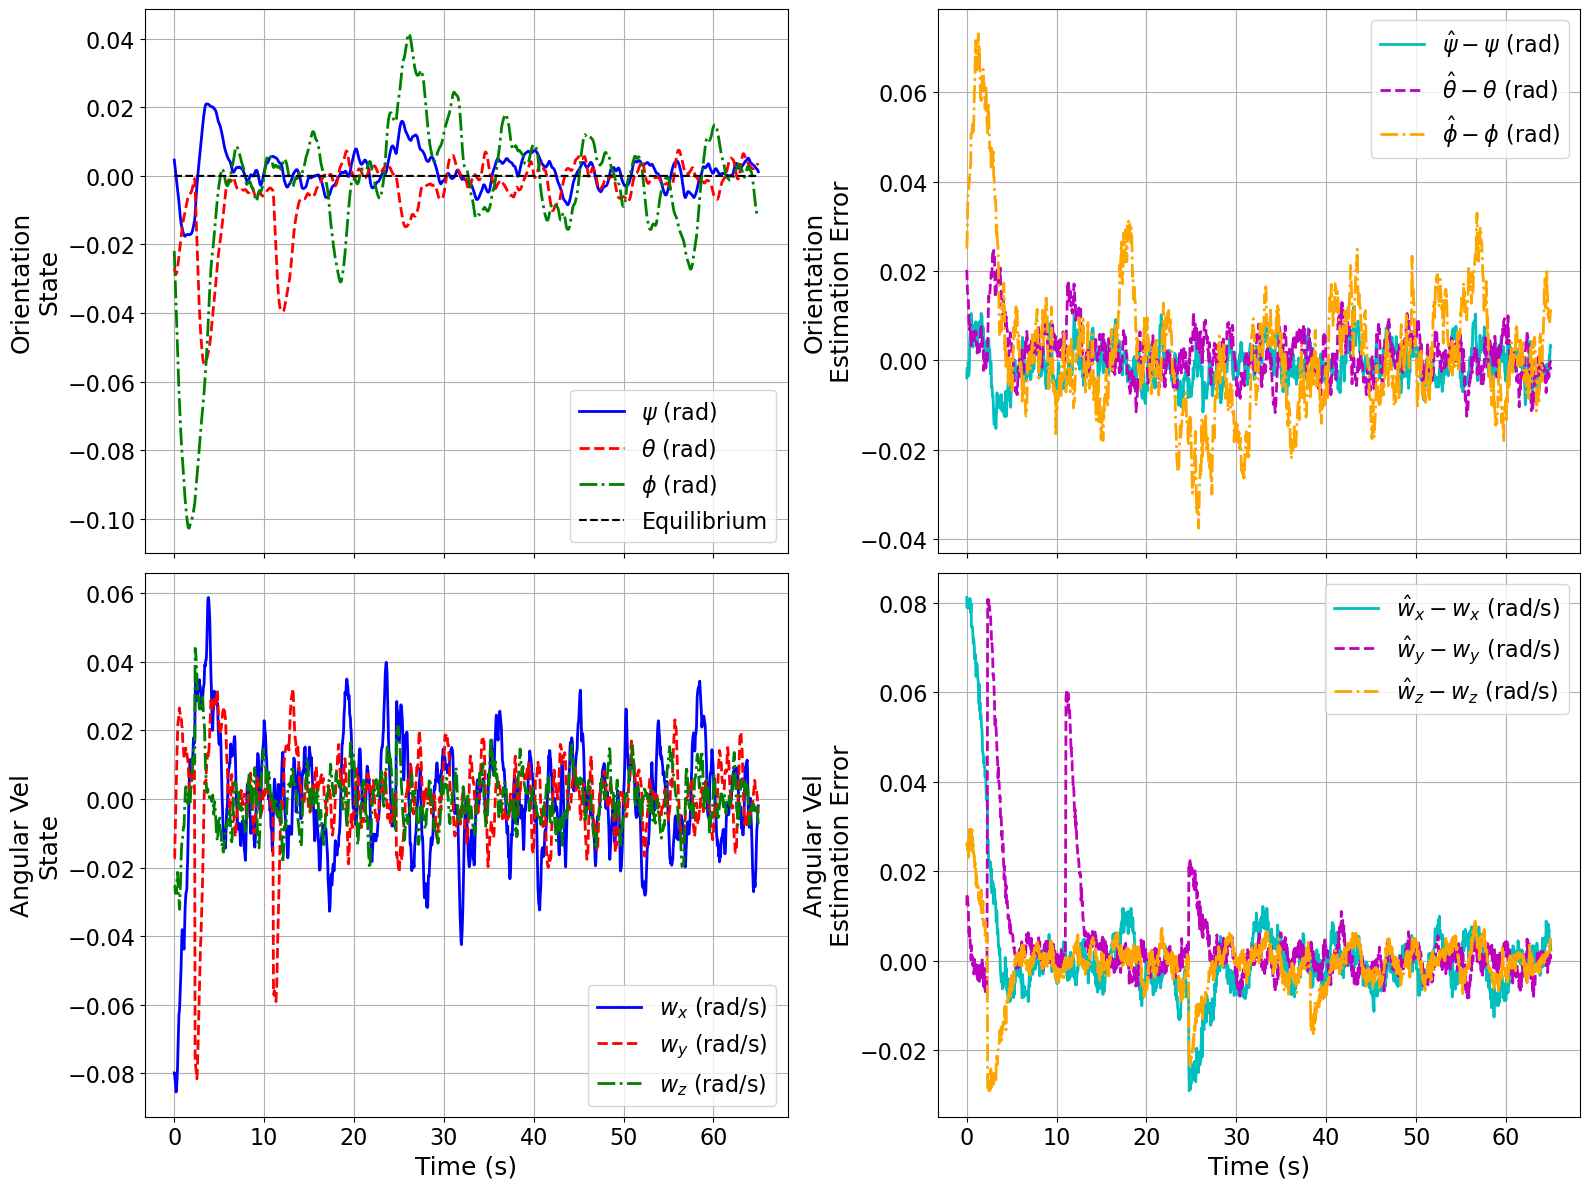

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots arranged in 2 rows and 2 columns for state and estimation error comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

xhat = data['xhat']  # Make code cleaner to read

# Line styles
line_styles = ['-', '--', '-.', ':']

# --- 1. Orientation: State error (x - 0) ---
axes[0, 0].plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=2, linestyle=line_styles[0], color='b')
axes[0, 0].plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=2, linestyle=line_styles[1], color='r')
axes[0, 0].plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=2, linestyle=line_styles[2], color='g')
axes[0, 0].plot(data['t'], np.zeros_like(data['t']), 'k--', linewidth=1.5, label='Equilibrium')
axes[0, 0].set_ylabel("Orientation\nState", fontsize=18)
axes[0, 0].legend(fontsize=16)
axes[0, 0].grid()

# --- 2. Orientation: Estimation error (xhat - x) ---
axes[0, 1].plot(data['t'], xhat[:, 0] - data['psi'], label=r'$\hat{\psi} - \psi$ (rad)', linewidth=2, linestyle=line_styles[0], color='c')
axes[0, 1].plot(data['t'], xhat[:, 1] - data['theta'], label=r'$\hat{\theta} - \theta$ (rad)', linewidth=2, linestyle=line_styles[1], color='m')
axes[0, 1].plot(data['t'], xhat[:, 2] - data['phi'], label=r'$\hat{\phi} - \phi$ (rad)', linewidth=2, linestyle=line_styles[2], color='orange')
axes[0, 1].set_ylabel("Orientation\nEstimation Error", fontsize=18)
axes[0, 1].legend(fontsize=16)
axes[0, 1].grid()

# --- 3. Angular velocity: State error (x - 0) ---
axes[1, 0].plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=2, linestyle=line_styles[0], color='b')
axes[1, 0].plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=2, linestyle=line_styles[1], color='r')
axes[1, 0].plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=2, linestyle=line_styles[2], color='g')
axes[1, 0].set_ylabel("Angular Vel\nState", fontsize=18)
axes[1, 0].legend(fontsize=16)
axes[1, 0].grid()
axes[1, 0].set_xlabel("Time (s)", fontsize=18)

# --- 4. Angular velocity: Estimation error (xhat - x) ---
axes[1, 1].plot(data['t'], xhat[:, 3] - data['w_x'], label=r'$\hat{w}_x - w_x$ (rad/s)', linewidth=2, linestyle=line_styles[0], color='c')
axes[1, 1].plot(data['t'], xhat[:, 4] - data['w_y'], label=r'$\hat{w}_y - w_y$ (rad/s)', linewidth=2, linestyle=line_styles[1], color='m')
axes[1, 1].plot(data['t'], xhat[:, 5] - data['w_z'], label=r'$\hat{w}_z - w_z$ (rad/s)', linewidth=2, linestyle=line_styles[2], color='orange')
axes[1, 1].set_ylabel("Angular Vel\nEstimation Error", fontsize=18)
axes[1, 1].set_xlabel("Time (s)", fontsize=18)
axes[1, 1].legend(fontsize=16)
axes[1, 1].grid()

# Final touches
for ax in axes.flat:
    ax.tick_params(labelsize=16)

fig.tight_layout()

This function runs multiple randomized simulations to evaluate controller performance. It returns the success rate, all collected data, and docking outcomes across trials. 

In [29]:
def set_iterate(simulator, controller, num_simulations=100):
    success_count = 0 # Initialize the counter for successful dockings
    all_data = [] # List to store the data from all simulations 
    all_docked = np.array([]) # Array to track whether each simulation resulted in a docking

    # Initialize the simulator without the visualizer to speed up the simulation
    simulator = ae353_spacecraft_simulate.Simulator(
        display=False,  
        seed=None, # No specific seed for randomization
    )

    for _ in range(num_simulations):
        simulator.reset(
            initial_conditions=None,
            scope_noise=0.1,        # Standard deviation of image noise for star tracker measurements
            space_debris=True,      # Whether or not there is space debris in the simulation
            docking_time=60.        # Time in seconds for the spacecraft to dock
        )
        controller.reset() # Reset controller before each simulation

        data = simulator.run(
            controller,           
            max_time=65.0,        # Maximum simulation time in seconds
            data_filename=None,   
            video_filename=None,  
            print_debug=False,   
        )
        # Check if the spacecraft successfully docked
        has_docked = simulator.has_docked()
        if has_docked:
            success_count += 1 # Increment success count if docking occurred
        # Append the simulation data to the list of all data
        all_data.append(data)
        all_docked = np.append(all_docked, has_docked)
    # Return the success rate (percentage of simulations that docked), all data, and docking results
    return (success_count / num_simulations, all_data, all_docked)



Creates a controller with precomputed values and runs multiple simulations using `set_iterate`.

In [30]:
def iterate(num_simulations=100):
    # Instantiate the Controller with precomputed parameters
    controller = Controller(
        K, L, A, B, C,          # Control and observer matrices
        psi_e, theta_e, phi_e,  # Equilibrium angles
        w_xe, w_ye, w_ze,       # Equilibrium angular velocities
        tau_1e, tau_2e, tau_3e, tau_4e,
        g_e
    )
    # Run the simulation batch using the set_iterate function

    return set_iterate(simulator, controller, num_simulations)


This code runs 100 simulations and visualizes how many times the spacecraft successfully docked versus failed, using a bar chart.

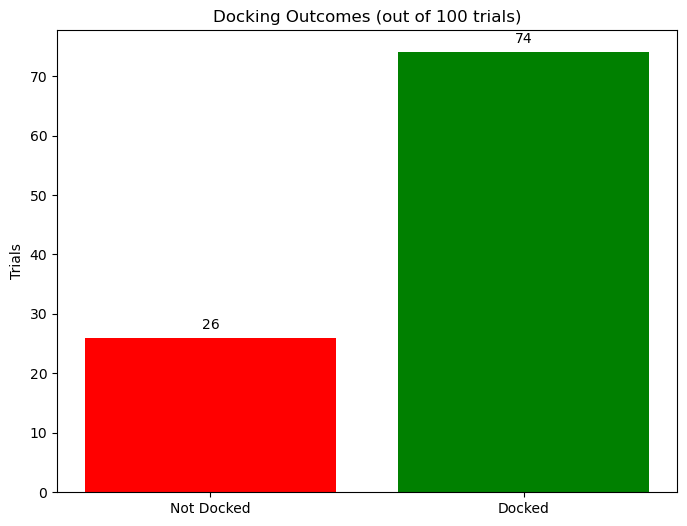

Success Rate: 0.74


In [31]:
# Run 100 simulations and gather docking success data
success_rate, all_data, all_docked = set_iterate(simulator, controller, num_simulations=100)

# Extract the final time value from each simulation's time series data
max_times = [time_data['t'][-1] for time_data in all_data]
sim_numbers = np.arange(1, len(all_data) + 1)

# Identify which simulations failed to dock
not_docked_indices = np.where(all_docked == False)[0]

# Count successes and failures
failure_count = len(not_docked_indices)
success_count = len(all_docked) - failure_count

# Create the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(['Not Docked', 'Docked'], [failure_count, success_count], color=['red', 'green'])
plt.ylabel("Trials")
plt.title("Docking Outcomes (out of 100 trials)")

# Add number labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

# Print success rate
print(f"Success Rate: {success_rate:.2f}")
